https://melhoresrodovias.org.br/indice-abcr/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pmdarima as pm
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
import warnings

warnings.filterwarnings("ignore")

2023-09-04 15:55:07.161345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 15:55:07.213287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 15:55:07.214114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 15:55:08.490551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Análise de Dados Exploratória

## Preparação do Conjunto de Dados

In [2]:
data_path = './dataset.xlsx' # insert the correct path and name of the file
case_df = pd.read_excel(data_path)

# set date as index
case_df.index = pd.to_datetime(case_df['data'], format='%Y-%m-%d')
case_df = case_df.drop('data', axis=1)
case_df

,abcr_leves,ici,pim,receita,ic_br_energia,preco_diesel,preco_etanol,reservas_internacionais,pmc_moveis_linha_branca,pmc_combustiveis_lubrificantes,pmc_roupa_calcados,pmc_alimentos_bebidas,selic_meta,pim_bens_consumo,pim_manufatura,pim_bens_intermediarios,pim_bens_capital
data,,,,,,,,,,,,,,,,,
2010-01-01,137.557654,108.9000,106.28638,74495.829991,47.1256,1.1386,1.0918,240484.0000,88.91831,96.27988,91.24382,78.42115,8.75,107.30917,106.14632,106.55851,100.85119
2010-02-01,118.380821,113.6000,103.65597,55082.064653,46.6218,1.1315,1.1138,241082.0000,73.95911,90.50721,82.44177,76.00021,8.75,107.18220,103.88948,101.59579,102.65056
2010-03-01,120.370806,116.1000,122.44795,60875.890076,42.7258,1.1240,1.0053,243762.0000,83.79243,102.25872,98.80615,83.95472,8.75,128.35996,123.12642,117.38226,129.42121
2010-04-01,121.795781,117.7000,115.72172,72460.799766,42.8074,1.1170,0.9237,247292.0000,76.36513,97.31072,108.72395,79.97747,9.50,118.10510,116.11801,113.71574,117.78302
2010-05-01,123.126608,117.0000,121.51816,62635.271956,43.6927,1.1100,0.8723,249846.0000,87.97682,102.36180,125.83217,80.84209,9.50,122.90152,122.00840,119.86104,124.18815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-08-01,NaN,99.7660,129.58940,265751.476600,107.6456,1.2985,1.0172,397472.3745,114.53220,135.91130,115.38100,117.62150,6.25,135.81100,132.62960,129.77080,133.84530
2030-09-01,NaN,99.6894,125.57520,263341.160400,107.6456,1.2985,1.0172,397900.2021,113.73490,138.74600,102.54390,118.45610,6.25,132.29820,127.96750,126.16840,123.66230
2030-10-01,NaN,98.1659,127.84010,299714.220700,107.6456,1.2985,1.0172,398328.0296,119.35240,143.83150,108.98700,126.18480,6.25,133.80420,128.88540,129.23820,125.32980


* 252 linhas e 17 colunas
* A descrição das variáveis está em [case.pdf](case.pdf)

In [3]:
case_df.describe()

,abcr_leves,ici,pim,receita,ic_br_energia,preco_diesel,preco_etanol,reservas_internacionais,pmc_moveis_linha_branca,pmc_combustiveis_lubrificantes,pmc_roupa_calcados,pmc_alimentos_bebidas,selic_meta,pim_bens_consumo,pim_manufatura,pim_bens_intermediarios,pim_bens_capital
count,162.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,147.561616,96.987567,107.801306,162382.780426,80.781072,1.224694,1.013028,362225.714407,108.146880,106.876532,112.503059,100.599569,8.840278,111.749261,107.898768,107.144878,102.953081
std,16.722342,8.974140,11.075728,72717.537432,31.856940,0.178195,0.112096,28138.480964,17.347130,13.362416,33.252912,12.076395,3.223117,12.861329,11.934011,10.305073,18.385198
min,72.487530,62.400000,70.246690,55082.064653,38.964000,0.985300,0.832700,240484.000000,59.084220,69.457470,18.218540,76.000210,2.000000,65.207500,67.291750,76.078490,42.500910
25%,138.369721,93.707200,100.507108,98020.113675,49.674925,1.091825,0.958400,356814.500000,96.714165,98.186928,94.709553,91.913088,6.250000,102.684137,99.883503,99.947160,89.163728
50%,149.383765,97.778200,107.541010,139565.430375,77.224950,1.205200,1.012450,367728.724300,105.029880,105.921445,106.926350,98.355000,8.375000,111.934800,107.401775,107.288015,104.022000
75%,156.533685,100.850000,115.784865,229979.047950,107.645600,1.298500,1.030550,377070.000000,116.616300,116.159185,119.413027,108.536125,11.250000,121.381947,116.731700,114.461050,117.784790
max,182.158013,117.700000,131.191890,329016.881800,180.294300,2.026900,1.552300,399183.684700,171.769250,143.831500,250.672560,144.709200,14.250000,141.652260,132.629600,129.770800,143.168610


* Temos **162** meses de dados sobre `abcr_leves` (2010-01-01 até 2023-06-01)
* Queremos prever essa variável para **90** meses futuros (2023-07-01 até 2031-12-01)

In [4]:
case_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2010-01-01 to 2030-12-01
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   abcr_leves                      162 non-null    float64
 1   ici                             252 non-null    float64
 2   pim                             252 non-null    float64
 3   receita                         252 non-null    float64
 4   ic_br_energia                   252 non-null    float64
 5   preco_diesel                    252 non-null    float64
 6   preco_etanol                    252 non-null    float64
 7   reservas_internacionais         252 non-null    float64
 8   pmc_moveis_linha_branca         252 non-null    float64
 9   pmc_combustiveis_lubrificantes  252 non-null    float64
 10  pmc_roupa_calcados              252 non-null    float64
 11  pmc_alimentos_bebidas           252 non-null    float64
 12  selic_meta       

In [5]:
case_df.index[161]

Timestamp('2023-06-01 00:00:00')

In [6]:
df_past = case_df[:'2023-06-01']
df_past

,abcr_leves,ici,pim,receita,ic_br_energia,preco_diesel,preco_etanol,reservas_internacionais,pmc_moveis_linha_branca,pmc_combustiveis_lubrificantes,pmc_roupa_calcados,pmc_alimentos_bebidas,selic_meta,pim_bens_consumo,pim_manufatura,pim_bens_intermediarios,pim_bens_capital
data,,,,,,,,,,,,,,,,,
2010-01-01,137.557654,108.9,106.28638,74495.829991,47.1256,1.1386,1.0918,240484.0,88.91831,96.27988,91.24382,78.42115,8.75,107.30917,106.14632,106.55851,100.85119
2010-02-01,118.380821,113.6,103.65597,55082.064653,46.6218,1.1315,1.1138,241082.0,73.95911,90.50721,82.44177,76.00021,8.75,107.18220,103.88948,101.59579,102.65056
2010-03-01,120.370806,116.1,122.44795,60875.890076,42.7258,1.1240,1.0053,243762.0,83.79243,102.25872,98.80615,83.95472,8.75,128.35996,123.12642,117.38226,129.42121
2010-04-01,121.795781,117.7,115.72172,72460.799766,42.8074,1.1170,0.9237,247292.0,76.36513,97.31072,108.72395,79.97747,9.50,118.10510,116.11801,113.71574,117.78302
2010-05-01,123.126608,117.0,121.51816,62635.271956,43.6927,1.1100,0.8723,249846.0,87.97682,102.36180,125.83217,80.84209,9.50,122.90152,122.00840,119.86104,124.18815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,148.810803,90.9,87.50041,158994.533469,102.5282,1.6163,1.0169,328098.0,85.89007,95.04321,71.15876,92.73729,13.75,86.99350,86.85412,88.05710,83.55314
2023-03-01,160.171350,95.4,99.32097,171056.362117,99.3095,1.5411,1.0442,341158.0,102.40505,106.13475,81.88834,101.62821,13.75,98.74199,99.11370,98.97884,105.25709
2023-04-01,158.040534,96.0,92.07883,203888.540483,98.7990,1.5001,1.0485,345725.0,88.78179,98.50652,86.91740,103.19666,13.75,90.47863,91.17776,94.06368,80.22211


In [7]:
df_future = case_df['2023-07-01':]
df_future

,abcr_leves,ici,pim,receita,ic_br_energia,preco_diesel,preco_etanol,reservas_internacionais,pmc_moveis_linha_branca,pmc_combustiveis_lubrificantes,pmc_roupa_calcados,pmc_alimentos_bebidas,selic_meta,pim_bens_consumo,pim_manufatura,pim_bens_intermediarios,pim_bens_capital
data,,,,,,,,,,,,,,,,,
2023-07-01,NaN,95.5602,108.6378,214314.8836,99.0141,1.3205,0.9765,348037.4931,96.5030,112.4531,96.6164,102.4647,13.75,111.4824,109.7962,109.2422,104.1562
2023-08-01,NaN,96.8202,110.4535,182332.4762,100.8889,1.2988,0.9859,351370.9922,96.8670,114.9486,97.5849,99.4798,13.50,114.8637,112.1731,109.7552,113.2013
2023-09-01,NaN,96.8910,107.0321,182670.1938,102.8967,1.2963,0.9879,354704.4912,96.1927,117.3462,86.7278,100.1858,13.00,111.8928,108.2301,106.7085,104.5889
2023-10-01,NaN,95.5534,108.9625,219603.7128,105.0435,1.3033,1.0040,358037.9902,100.9437,121.6472,92.1770,106.7223,12.50,113.1665,109.0063,109.3047,105.9992
2023-11-01,NaN,93.3703,102.1935,193832.3845,106.7267,1.3078,1.0162,361371.4892,127.5961,107.0122,97.6818,104.1963,12.50,107.4966,104.0803,101.4931,104.2187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-08-01,NaN,99.7660,129.5894,265751.4766,107.6456,1.2985,1.0172,397472.3745,114.5322,135.9113,115.3810,117.6215,6.25,135.8110,132.6296,129.7708,133.8453
2030-09-01,NaN,99.6894,125.5752,263341.1604,107.6456,1.2985,1.0172,397900.2021,113.7349,138.7460,102.5439,118.4561,6.25,132.2982,127.9675,126.1684,123.6623
2030-10-01,NaN,98.1659,127.8401,299714.2207,107.6456,1.2985,1.0172,398328.0296,119.3524,143.8315,108.9870,126.1848,6.25,133.8042,128.8854,129.2382,125.3298


### Visualização dos Dados

In [8]:
fig = px.line(
    df_past,
    markers=True,
    x=df_past.index,
    y="abcr_leves",
    title="ABC-R Leves",
    labels={"abcr_leves": "Valor ABCR Leves", "data": "Ano"},
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

* Forte impacto da Pandemia de COVID-19 em 2020, principalmente nos meses de março, abril e maio
* Leve recuperação em setembro de 2020
* Nova queda em março de 2021

In [9]:
# create a stacked data frame with `abcr_leves` for each year
df_stack_abcr = pd.DataFrame()
df_stack_abcr['2017'] = case_df['2017-01-01':'2017-12-01']['abcr_leves'].values
df_stack_abcr['2018'] = case_df['2018-01-01':'2018-12-01']['abcr_leves'].values
df_stack_abcr['2019'] = case_df['2019-01-01':'2019-12-01']['abcr_leves'].values
df_stack_abcr['2020'] = case_df['2020-01-01':'2020-12-01']['abcr_leves'].values
df_stack_abcr['2021'] = case_df['2021-01-01':'2021-12-01']['abcr_leves'].values
df_stack_abcr['2022'] = case_df['2022-01-01':'2022-12-01']['abcr_leves'].values
df_stack_abcr.set_index(['Jan, Fev, Mar, Abr, Mai, Jun, Jul, Ago, Set, Out, Nov, Dez'.split(',')], inplace=True)
df_stack_abcr

,2017,2018,2019,2020,2021,2022
Jan,172.218750,175.049538,179.223204,178.633211,157.421123,156.857845
Fev,145.060767,145.318357,141.908075,149.766267,133.708037,138.824885
Mar,151.602231,155.520978,157.001567,116.872604,115.806020,152.124807
Abr,150.263557,151.199980,151.111258,72.487530,114.817919,149.677225
Mai,146.746845,131.212901,148.240480,85.786744,132.938668,144.402194
Jun,144.133977,133.420266,144.931421,101.701910,129.956027,137.340096
Jul,161.972520,156.860789,160.268297,120.575847,148.671858,162.965495
Ago,147.501016,146.926362,151.333149,128.007346,142.416659,151.004024
Set,153.157462,151.039396,155.913742,141.162076,145.504516,151.010926
Out,155.341207,151.927642,161.567915,153.559544,150.527100,157.201742


In [10]:
df_stack_abcr.describe()

,2017,2018,2019,2020,2021,2022
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,154.664299,152.498122,157.512763,129.949786,141.217729,152.341474
std,10.727701,13.906356,12.086638,31.958374,16.882689,10.699790
min,144.133977,131.212901,141.908075,72.487530,114.817919,137.340096
25%,147.312473,146.524361,150.393564,113.079931,132.193008,148.286279
50%,150.932894,151.563811,156.457654,134.584711,143.960588,151.007475
75%,156.999035,155.855931,160.593201,150.714586,149.516716,156.943819
max,177.806054,178.702503,180.787050,178.633211,173.664900,177.107470


In [11]:
# plot stacked bar chart
fig = px.line(
    df_stack_abcr,
    x=df_stack_abcr.index,
    y=["2017", "2018", "2019", "2020", "2021", "2022"],
    title="ABCR Leves Em Cada Ano",
    markers=True,
    labels={"index": "Meses", "value": "Valor ABCR Leves", "variable": "Ano"},
)
fig.show()

* Verificamos que o índice ABCR de veículos leves segue uma tendência sazonal e mantém os padrões para cada mês do ano
* Os anos de 2020 e 2021 podem ser considerados anomalias

### Decomposição da Série Temporal

In [12]:
def plot_seasonal_decompose(
    result: DecomposeResult,
    dates: pd.Series = None,
    title: str = "Seasonal Decomposition",
):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name="Observed"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name="Trend"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name="Seasonal"),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name="Residual"),
            row=4,
            col=1,
        )
        .update_layout(
            height=900,
            title=f"<b>{title}</b>",
            margin={"t": 100},
            title_x=0.5,
            showlegend=False,
        )
    )

In [13]:
fig = plot_seasonal_decompose(seasonal_decompose(df_past['abcr_leves'], model='additive'), title='Seasonal Decomposition - ABCR Leves')
fig.show()

# Forecasting com LSTM

## Análise de Variáveis (Features)

### Correlação entre Variáveis

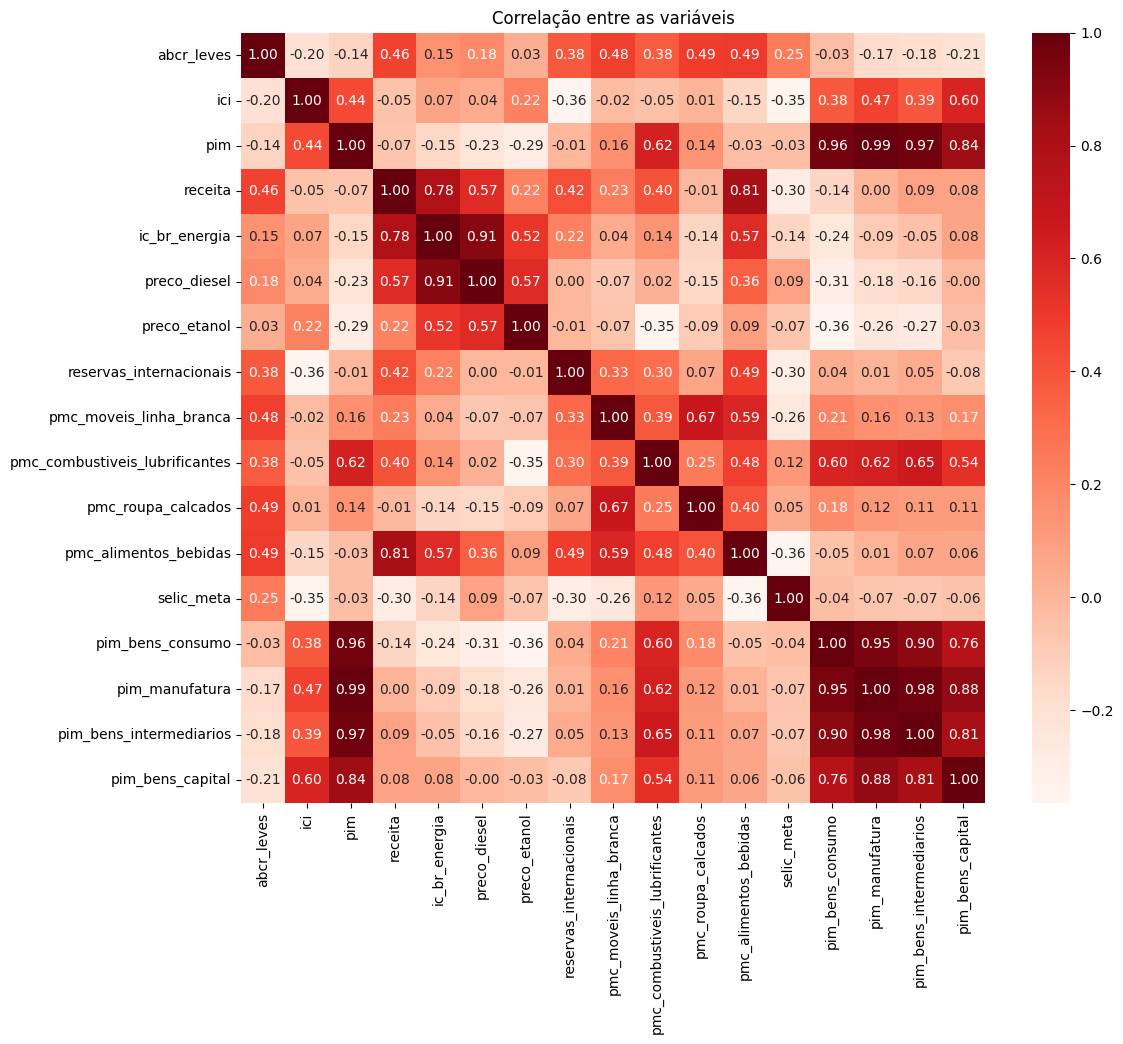

In [14]:
plt.figure(figsize=(12, 10))
cor = case_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.title("Correlação entre as variáveis")
plt.show()

Principais Correlações:
* variáveis de **Pesquisa Industrial Mensal** ("pim", "pim_bens_consumo", "pim_manufatura", "pim_bens_intermediarios")
* **preco_diesel** e **ic_br_energia**
* **pmc_alimento_bebidas** e **receita**

In [15]:
fig = px.line(
    df_past,
    x=df_past.index,
    y=["pim", "pim_bens_consumo", "pim_manufatura", "pim_bens_intermediarios"],
    title="Pesquisa Industrial Mensal",
    labels={"value": "Valor", "data": "Ano", "variable": "Indicador"},
)
fig.show()

In [16]:
fig = px.line(
    df_past,
    x=df_past.index,
    y=["preco_etanol", "preco_diesel"],
    title="Preço Etanol e Diesel",
    labels={"value": "Valor", "data": "Ano", "variable": "Combustível"},
)
fig.show()

* O preço do Diesel e do Etanol possuem correlação, mas em alguns períodos distoam
* Talvez fosse interessante ter uma variável única para combustíveis, como o preço do barril de petróleo

In [17]:
fig = px.line(
    df_past,
    x=df_past.index,
    y=[
        "pmc_moveis_linha_branca",
        "pmc_combustiveis_lubrificantes",
        "pmc_roupa_calcados",
        "pmc_alimentos_bebidas",
    ],
    title="Pesquisa Mensal de Comércio",
    labels={"value": "Valor", "data": "Ano", "variable": "Indicador"},
)
fig.show()

### Seleção de Variáveis

In [18]:
select_df = df_past.drop(
    columns=[
        "pim_bens_consumo",
        "pim_manufatura",
        "pim_bens_intermediarios",
        "pim_bens_capital",
        "ic_br_energia",
        "reservas_internacionais",
        "pmc_moveis_linha_branca",
        "pmc_alimentos_bebidas",
    ]
)
select_df.head()

,abcr_leves,ici,pim,receita,preco_diesel,preco_etanol,pmc_combustiveis_lubrificantes,pmc_roupa_calcados,selic_meta
data,,,,,,,,,
2010-01-01,137.557654,108.9,106.28638,74495.829991,1.1386,1.0918,96.27988,91.24382,8.75
2010-02-01,118.380821,113.6,103.65597,55082.064653,1.1315,1.1138,90.50721,82.44177,8.75
2010-03-01,120.370806,116.1,122.44795,60875.890076,1.1240,1.0053,102.25872,98.80615,8.75
2010-04-01,121.795781,117.7,115.72172,72460.799766,1.1170,0.9237,97.31072,108.72395,9.50
2010-05-01,123.126608,117.0,121.51816,62635.271956,1.1100,0.8723,102.36180,125.83217,9.50


In [19]:
select_df.describe()

,abcr_leves,ici,pim,receita,preco_diesel,preco_etanol,pmc_combustiveis_lubrificantes,pmc_roupa_calcados,selic_meta
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,147.561616,97.046914,107.020127,115543.111394,1.184309,1.013733,101.958804,113.982598,9.408951
std,16.722342,11.075871,11.611615,37311.369918,0.211851,0.139333,11.657468,36.008477,3.581977
min,72.487530,62.400000,70.246690,55082.064653,0.985300,0.832700,69.457470,18.218540,2.000000
25%,138.369721,90.825000,99.660950,90048.032617,1.072800,0.930825,94.026358,95.417372,6.500000
50%,149.383765,98.250000,106.194305,106038.844939,1.109100,0.982600,101.617140,108.713825,10.000000
75%,156.533685,104.625000,113.822458,137336.014661,1.177450,1.046775,110.969268,120.625320,12.250000
max,182.158013,117.700000,131.191890,251744.502812,2.026900,1.552300,128.751150,250.672560,14.250000


## Preparação do Conjunto de Dados

In [20]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(select_df)

In [21]:
X_train = []
y_train = []

n_future = 1
n_past = 12

for i in range(n_past, len(scaled_data) - n_future + 1):
    X_train.append(scaled_data[i - n_past : i, 0 : scaled_data.shape[1]])
    y_train.append(scaled_data[i + n_future - 1 : i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((150, 12, 9), (150, 1))

## Criação do Modelo

In [22]:
model = Sequential()
model.add(
    LSTM(
        128,
        activation="relu",
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=True,
    )
)
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(123, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           70656     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 123)           123984    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 123)           0         
                                                                 
 dropout (Dropout)           (None, 12, 123)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                48128     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [23]:
history = model.fit(
    X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1
)

Epoch 1/50
5/5 [==============================] - 6s 271ms/step - loss: 0.2538 - val_loss: 0.1201
Epoch 2/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0920 - val_loss: 0.0173
Epoch 3/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0612 - val_loss: 0.0475
Epoch 4/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0522 - val_loss: 0.0120
Epoch 5/50
5/5 [==============================] - 0s 35ms/step - loss: 0.0408 - val_loss: 0.0299
Epoch 6/50
5/5 [==============================] - 0s 36ms/step - loss: 0.0397 - val_loss: 0.0104
Epoch 7/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0366 - val_loss: 0.0122
Epoch 8/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0321 - val_loss: 0.0105
Epoch 9/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0292 - val_loss: 0.0147
Epoch 10/50
5/5 [==============================] - 0s 34ms/step - loss: 0.0272 - val_loss: 0.0086
Epoch 11/50
5/5 [===========

## Forecasting para os próximos 90 meses

In [24]:
forecast_size = 90
forecast = model.predict(X_train[-forecast_size:])

3/3 [==============================] - 1s 12ms/step


In [25]:
forecast_copies = np.repeat(forecast, select_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:, 0]

In [26]:
df_forecast = pd.DataFrame(
    {"abcr_leves_pred": y_pred_future}, index=case_df[-forecast_size:].index
)

In [27]:
# plot
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=case_df.index,
        y=case_df["abcr_leves"],
        name="Valor ABC-R Leves",
        mode="lines+markers",
    )
)
fig.add_trace(
    go.Scatter(
        x=df_forecast.index,
        y=df_forecast["abcr_leves_pred"],
        line_color="rgba(247, 131, 7, 0.8)",
        name="Forecast",
        mode="lines+markers",
    )
)
fig.update_layout(
    title="ABC-R Leves 2010 a 2030 - Previsão LSTM",
    xaxis_title="Ano",
    yaxis_title="Valor ABC-R Leves",
)
fig.show()

## Conclusão

#### Resultados

* O modelo LSTM não obteve uma boa performance para prever o índice ABCR de veículos leves para os próximos 90 meses.
* Foram realizados alguns testes com modificações nos parâmetros do modelo, mas não houve melhora significativa.
* Possivelmente, o modelo **não obteve uma boa performance** devido à forte influência da Pandemia de COVID-19 nos dados de 2020 e 2021. Isso é agravado em **séries temporais**, pois geralmente utilizamos os **últimos dados** para teste e validação do modelo. Além disso, o forecasting utiliza a **janela de dados mais recente para prever os próximos valores**, isso leva a um efeito de "acumulação de erros" ao longo do tempo.

#### Possíveis melhorias

* Realizar um processo de *Feature Engineering* mais elaborado, com a criação de novas variáveis e a seleção de variáveis mais relevantes para o modelo
* Testes com outros modelos e/ou algoritmos de *Machine Learning* 
* Utilizar técnicas para tratar anomalias nos dados

# Forecasting com ARIMA

## Verifição de estacionariedade

### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test

* `hipótese nula`: a série **não** é estacionária
* `hipótese alternativa`: a série é estacionária, possui raiz unitária

In [28]:
# "ct" param means constant and trend
stats, p, lags, critical_values = kpss(df_past["abcr_leves"], regression="ct", nlags=12)

print(f"Test Statistic: {stats}")
print(f"p-value: {p}")
print(f"Critical Values: {critical_values}")

# test
if p < 0.05:
    print("Série NÃO é estacionária")
else:
    print("Série é estacionária")

Test Statistic: 0.18600246356389127
p-value: 0.02124907616354077
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Série NÃO é estacionária


### Augmented Dickey–Fuller (ADF) test

* `hipótese nula`: a série possui raiz unitária, **não** é estacionária
* `hipótese alternativa`: a série é estacionária

In [29]:
result = adfuller(df_past["abcr_leves"])

print(f"Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

# test
if result[1] > 0.05:
    print("Série NÃO é estacionária")
else:
    print("Série é estacionária")

Test Statistic: -2.3871735889855707
p-value: 0.1453893418002185
Critical Values: {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}
Série NÃO é estacionária


## Criação do Modelo

### Testar melhores parâmetros para o modelo ARIMA

In [30]:
pm.auto_arima(
    df_past["abcr_leves"],
    m=12,
    seasonal=True,
    start_p=0,
    start_q=0,
    max_order=4,
    test="adf",
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1310.564, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1375.359, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1174.819, Time=0.57 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1244.914, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2081.926, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1284.759, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1171.640, Time=1.49 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1158.625, Time=0.78 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1220.742, Time=0.40 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=1207.550, Time=2.46 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1200.189, Time=1.10 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=1164.061, Time=0.96 sec
 ARIMA(1,0,1)(1,0,1)[12] inte

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

### Treinar o modelo com os melhores parâmetros

In [31]:
sarimax_model = SARIMAX(
    df_past["abcr_leves"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)
)
sarrimax_result = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28314D+00    |proj g|=  1.34218D+00

At iterate    5    f=  3.79013D+00    |proj g|=  3.89585D-02


 This problem is unconstrained.



At iterate   10    f=  3.59335D+00    |proj g|=  1.68678D-02

At iterate   15    f=  3.58379D+00    |proj g|=  1.71817D-02

At iterate   20    f=  3.57396D+00    |proj g|=  1.30293D-02

At iterate   25    f=  3.56919D+00    |proj g|=  7.46624D-03

At iterate   30    f=  3.56263D+00    |proj g|=  1.25827D-02

At iterate   35    f=  3.55069D+00    |proj g|=  1.39978D-03

At iterate   40    f=  3.55066D+00    |proj g|=  5.30882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     71      1     0     0   1.501D-04   3.551D+00
  F =   3.5506633970701107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [32]:
sarrimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         abcr_leves   No. Observations:                  162
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -575.207
Date:                            Mon, 04 Sep 2023   AIC                           1160.415
Time:                                    15:56:11   BIC                           1175.853
Sample:                                01-01-2010   HQIC                          1166.683
                                     - 06-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9529      0.027     35.139      0.000       0.900       1.006
ma.L1          0.0358      0.050      0.718      0.473      -0.062       0.134
ar.S.L12       0.9996      0.003    386.456      0.000       0.995       1.005
ma.S.L12      -0.9516      0.164     -5.795      0.000      -1.273      -0.630
sigma2        55.0250      7.998      6.880      0.000      39.350      70.700
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               724.96
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               4.57   Skew:                            -1.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Avaliar o modelo para último ano

In [33]:
predictions = sarrimax_result.get_prediction(start=-12)
predictions_ci = predictions.conf_int()
predictions_mean = predictions.predicted_mean
predictions_lower = predictions_ci.iloc[:, 0]
predictions_upper = predictions_ci.iloc[:, 1]

In [34]:
predictions_dates = np.asarray(predictions_mean.index)
dates = np.asarray(df_past.index)

In [35]:
# plot with filled area for confidence interval (upper and lower)
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df_past['2020-01-01':].index, y=df_past["abcr_leves"], name="Valor ABC-R Leves", mode="lines+markers")
)
fig.add_trace(
    go.Scatter(x=predictions_dates, y=predictions_mean.values, name="Previsão")
)
fig.add_trace(
    go.Scatter(
        x=predictions_dates,
        y=predictions_lower,
        fill=None,
        mode="lines",
        line_color="rgba(255, 0, 0, 0.3)",
        name="Limite Inferior",
    )
)
fig.add_trace(
    go.Scatter(
        x=predictions_dates,
        y=predictions_upper,
        fill="tonexty",
        mode="lines",
        line_color="rgba(200, 75, 100, 0.3)",
        name="Limite Superior",
    )
)
fig.update_layout(
    title="Previsão ABC-R Leves", xaxis_title="Ano", yaxis_title="Valor ABC-R Leves"
)
fig.show()

O modelo ARIMA obteve bons resultados para prever o índice ABCR de veículos leves para o ano de 2023, porém seu intervalo de confiança está no limite.

### Forecasting para os próximos 90 meses

In [36]:
forecast = sarrimax_result.get_forecast(steps=90)
forecast_ci = forecast.conf_int()
forecast_mean = forecast.predicted_mean
forecast_lower = forecast_ci.iloc[:, 0]
forecast_upper = forecast_ci.iloc[:, 1]

In [37]:
forecast_dates = np.asarray(forecast_mean.index)
dates = np.asarray(case_df.index)

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_past.index, y=df_past["abcr_leves"], name="ABC-R Leves", mode="lines+markers"))
fig.add_trace(
    go.Scatter(
        x=forecast_dates,
        y=forecast_mean.values,
        name="Forecast",
        mode="lines+markers",
        line_color="rgba(247, 131, 7, 0.8)",
    )
)
fig.update_layout(
    title="ABC-R Leves 2010 a 2030 - Previsão ARIMA",
    xaxis_title="Ano",
    yaxis_title="Valor ABC-R Leves",
)
fig.show()

### Conclusão

#### Resultados
* O modelo ARIMA obteve uma boa performance para prever o índice ABCR de veículos leves para os próximos 90 meses.
* As características da série temporal foram bem capturadas pelo modelo, portanto a sazonalidade e a tendência foram bem previstas.
* Os resultados se monstram muito superiores ao modelo LSTM, mesmo considerando apenas a variável `abcr_leves`

#### Possíveis melhorias
* Testes com variações nos parâmetros do modelo
* Utilizar técnicas para tratar anomalias nos dados